Questions: 

Why are customers complaning?
How can we reduce customer complaints?
How can we prevent disputes?

Plan for this project:

Do operations using pyspark and pandas:
- time the operations and keep track of memory usage
- show that memory and time usage was reduced with using pyspark over pandas


Clean data:
- handle null values
- remove repeats
- converting datatypes
- handling outliers (either keep or remove)

Perform some EDA
- determine nature of customer complaints
- try to find other useful information using visuals
  
- visuals to figure out distrubtions of variables and calculate statistical measures (showcause descriptive statistical knowledge)
- make hypothesis and use statistical tests to come to conclusions (showcase inferental statistical knowledge)

- remove certain columns
- feature engineering (for example handling the complains column)

Create a dashboard in PowerBI

In [1]:
import time 
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
import pandas as pd
import numpy as np
import seaborn as sns

# Using Spark

In [9]:
# Initialize a Spark session
spark = SparkSession.builder \
    .appName("CSV Loader") \
    .getOrCreate()

# Load the CSV file into a DataFrame
spark_data = spark.read.csv('complaints.csv', header=True, inferSchema=True)

# Show the first few rows of the DataFrame
spark_data.show()

+-------------+--------------------+--------------------+--------------------+--------------------+----------------------------+-----------------------+--------------------+-----+--------+----+--------------------------+-------------+--------------------+----------------------------+----------------+------------------+------------+
|Date received|             Product|         Sub-product|               Issue|           Sub-issue|Consumer complaint narrative|Company public response|             Company|State|ZIP code|Tags|Consumer consent provided?|Submitted via|Date sent to company|Company response to consumer|Timely response?|Consumer disputed?|Complaint ID|
+-------------+--------------------+--------------------+--------------------+--------------------+----------------------------+-----------------------+--------------------+-----+--------+----+--------------------------+-------------+--------------------+----------------------------+----------------+------------------+------------

In [3]:
data.describe().show()

+-------+--------------------+--------------------+--------------------+--------------------+--------------------+----------------------------+-----------------------+--------------------+--------------------+--------------------+--------------------+--------------------------+--------------------+--------------------+----------------------------+--------------------+--------------------+--------------------+
|summary|       Date received|             Product|         Sub-product|               Issue|           Sub-issue|Consumer complaint narrative|Company public response|             Company|               State|            ZIP code|                Tags|Consumer consent provided?|       Submitted via|Date sent to company|Company response to consumer|    Timely response?|  Consumer disputed?|        Complaint ID|
+-------+--------------------+--------------------+--------------------+--------------------+--------------------+----------------------------+-----------------------+-------

In [47]:
counts = spark_data.groupBy('State').count()

In [48]:
df = counts.toPandas()

KeyboardInterrupt: 

In [46]:
df.head()

,State,count
0,2023-01-21,271
1,2022-10-05,311
2,2023-05-18,414
3,I was told I needed to pay a fee for somethin...,1
4,it's the only correspondence I've received re...,1


In [30]:
df = df.fillna('nan')

In [41]:
np.array(df['count'])

array([271, 311, 414, ...,   1,   1,   1], dtype=int64)

In [43]:
df['State'].unique()

array(['2023-01-21', '2022-10-05', '2023-05-18', ...,
       ' "" Pursuant to your request', ' as well as individual incidents',
       ' including "" whether there were any hidden fees \'\'. XXXX repeatedly stated that the account was totally free. He also told me that I would be given a {$150.00} bonus if I set up direct deposit. Based on his extensive information and answers'],
      dtype=object)

In [ ]:
start = time.time()
plt.bar(df['State'].unique(), np.array(df['count']))
print(time.time() - start)

In [2]:
data.head()

Row(Date received='2024-06-20', Product='Credit reporting or other personal consumer reports', Sub-product='Credit reporting', Issue='Improper use of your report', Sub-issue='Reporting company used your report improperly', Consumer complaint narrative=None, Company public response=None, Company='Experian Information Solutions Inc.', State='AZ', ZIP code='85142', Tags=None, Consumer consent provided?=None, Submitted via='Web', Date sent to company='2024-06-20', Company response to consumer='In progress', Timely response?='Yes', Consumer disputed?='N/A', Complaint ID='9309148')

# Using Pandas

In [2]:
data = pd.read_csv('complaints.csv')
data.head()


KeyboardInterrupt



In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5492527 entries, 0 to 5492526
Data columns (total 18 columns):
 #   Column                        Dtype 
---  ------                        ----- 
 0   Date received                 object
 1   Product                       object
 2   Sub-product                   object
 3   Issue                         object
 4   Sub-issue                     object
 5   Consumer complaint narrative  object
 6   Company public response       object
 7   Company                       object
 8   State                         object
 9   ZIP code                      object
 10  Tags                          object
 11  Consumer consent provided?    object
 12  Submitted via                 object
 13  Date sent to company          object
 14  Company response to consumer  object
 15  Timely response?              object
 16  Consumer disputed?            object
 17  Complaint ID                  int64 
dtypes: int64(1), object(17)
memory usage: 754.

In order to reduce memory usage and make this dataset easier to handle, we should normalize it
Splitting this dataset up into many smaller datasets will make it easier to preprocess and analyze

In [3]:
data.isna().sum()

Date received                         0
Product                               0
Sub-product                      235295
Issue                                 6
Sub-issue                        739641
Consumer complaint narrative    3575480
Company public response         2842574
Company                               0
State                             46266
ZIP code                          30226
Tags                            4996793
Consumer consent provided?      1061775
Submitted via                         0
Date sent to company                  0
Company response to consumer         16
Timely response?                      0
Consumer disputed?              4724211
Complaint ID                          0
dtype: int64

In [44]:
data.fillna("Missing Value", inplace=True)

In [4]:
data.isna().sum()

Date received                   0
Product                         0
Sub-product                     0
Issue                           0
Sub-issue                       0
Consumer complaint narrative    0
Company public response         0
Company                         0
State                           0
ZIP code                        0
Tags                            0
Consumer consent provided?      0
Submitted via                   0
Date sent to company            0
Company response to consumer    0
Timely response?                0
Consumer disputed?              0
Complaint ID                    0
dtype: int64

## Normalization

Our normalization scheme will be as follows:

Consumer Table:
- Consumer ID
- Consumer complaint narrative
- Consumer consent provided?
- Consumer disputed?

Products Table:
- Product ID
- Product 
- Sub-product

Complaint Table:
- Complaint ID
- Date recieved
- Issue
- Sub-issue
- Tags
- Submitted via
- Date sent to company
- Company response to consumer
- Timely response?

(Foriegn Keys)
- Consumer ID
- Company ID
- Product ID

In [15]:
# Create unique identifiers (IDs) for each table
data['CustomerID'] = data.index
data['ProductID'] = data.groupby(['Product', 'Sub-product']).ngroup()
data['CompanyID'] = data.groupby(['Company', 'State']).ngroup()
data['ComplaintID'] = data['Complaint ID']  

# Create separate DataFrames for each table
customer_data = data[['CustomerID', 'Consumer complaint narrative', 'Consumer consent provided?', 'Consumer disputed?', 'ZIP code']]
product_data = data[['ProductID', 'Product', 'Sub-product']].drop_duplicates().reset_index(drop=True)
complaint_data = data[['ComplaintID', 'Date received', 'Issue', 'Sub-issue', 'Tags', 'Submitted via', 'Date sent to company', 'Company response to consumer', 'Timely response?', 'CustomerID', 'ProductID', 'CompanyID']]
company_data = data[['CompanyID', 'Company', 'Company public response', 'State']].drop_duplicates().reset_index(drop=True)

# Save to new csv files
customer_data.to_csv('customer_data.csv', index=False)
product_data.to_csv('product_data.csv', index=False)
complaint_data.to_csv('complaint_data.csv', index=False)
company_data.to_csv('company_data.csv', index=False)


Now lets calculate the amount of memory saved through normalization

In [34]:
normalized_tables = ((customer_data.memory_usage(deep=True).sum() + complaint_data.memory_usage(deep=True).sum() + product_data.memory_usage(deep=True).sum() + company_data.memory_usage(deep=True).sum()) / (1024 ** 3)) 

In [38]:
normalized_tables

6.485530646517873

In [45]:
original_table = (data.memory_usage(deep=True).sum() / (1024 ** 3))

In [46]:
original_table

8.4986142963171

In [47]:
(original_table - normalized_tables) / original_table * 100

23.6871986374485

In [49]:
del data

## Data Preprocessing

In [3]:
customer_data = pd.read_csv('customer_data.csv')
product_data = pd.read_csv('product_data.csv')
complaint_data = pd.read_csv('complaint_data.csv')
company_data = pd.read_csv('company_data.csv')

In [10]:
company_data = company_data.replace("Missing Value", np.nan)
product_data = product_data.replace("Missing Value", np.nan)
customer_data = customer_data.replace("Missing Value", np.nan)
complaint_data = complaint_data.replace("Missing Value", np.nan)

### info related to products

In [11]:
product_data.isna().sum()

ProductID      0
Product        0
Sub-product    6
dtype: int64

In [14]:
product_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ProductID    126 non-null    int64 
 1   Product      126 non-null    object
 2   Sub-product  120 non-null    object
dtypes: int64(1), object(2)
memory usage: 3.1+ KB


In [34]:
product_data.Product.unique()

array(['Credit reporting or other personal consumer reports',
       'Checking or savings account', 'Debt collection', 'Prepaid card',
       'Mortgage', 'Money transfer, virtual currency, or money service',
       'Credit card', 'Vehicle loan or lease',
       'Debt or credit management', 'Student loan',
       'Payday loan, title loan, personal loan, or advance loan',
       'Credit reporting, credit repair services, or other personal consumer reports',
       'Bank account or service', 'Credit card or prepaid card',
       'Payday loan, title loan, or personal loan', 'Credit reporting',
       'Consumer Loan', 'Payday loan', 'Money transfers',
       'Other financial service', 'Virtual currency'], dtype=object)

In [33]:
null_mask = product_data.isnull()

null_columns = product_data.loc[:, null_mask.any()]

null_mask = product_data.isnull().any(axis=1)

rows_with_nulls = product_data[null_mask]

print(rows_with_nulls)

     ProductID                                    Product Sub-product
77          27                           Credit reporting         NaN
80          17                                Credit card         NaN
81           7                Checking or savings account         NaN
89          90                                Payday loan         NaN
122         92  Payday loan, title loan, or personal loan         NaN
123         23                Credit card or prepaid card         NaN


In [28]:
product_data['Sub-product'].unique()

array(['Credit reporting', 'Checking account', 'I do not know',
       'General-purpose prepaid card',
       'Home equity loan or line of credit (HELOC)',
       'Mobile or digital wallet',
       'General-purpose credit card or charge card', 'Other debt',
       'FHA mortgage', 'Credit card debt', 'Savings account',
       'Other banking product or service', 'Rental debt', 'Loan',
       'Medical debt', 'Conventional home mortgage', 'Lease',
       'Virtual currency', 'Debt settlement',
       'Federal student loan servicing', 'Other personal consumer report',
       'Personal line of credit', 'Gift card', 'Private student loan',
       'VA mortgage', 'Telecommunications debt', 'Store credit card',
       'Auto debt', 'Government benefit card',
       'International money transfer', 'Check cashing service',
       'Domestic (US) money transfer', 'Installment loan',
       'Mortgage debt', 'Payday loan debt', 'Manufactured home loan',
       'Private student loan debt', 'Other type of

In [35]:
product_data.fillna("Other", inplace=True)

### info related to company

In [ ]:
company_data = pd.read_csv('company_data.csv')
company_data = company_data.replace("Missing Value", np.nan)

In [56]:
company_data.isna().sum()

CompanyID                      0
Company                        0
Company public response    58785
State                       2533
dtype: int64

In [57]:
company_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108969 entries, 0 to 108968
Data columns (total 4 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   CompanyID                108969 non-null  int64 
 1   Company                  108969 non-null  object
 2   Company public response  50184 non-null   object
 3   State                    106436 non-null  object
dtypes: int64(1), object(3)
memory usage: 3.3+ MB


In [40]:
company_data['State'].isna().sum() / company_data['State'].isna().count() * 100

2.3245143114096667

In [58]:
company_data = company_data[company_data['State'].notna()]

In [59]:
company_data.isna().sum()

CompanyID                      0
Company                        0
Company public response    57322
State                          0
dtype: int64

In [60]:
company_data['Company public response'].unique()

array([nan,
       'Company has responded to the consumer and the CFPB and chooses not to provide a public response',
       'Company believes it acted appropriately as authorized by contract or law',
       'Company believes complaint represents an opportunity for improvement to better serve consumers',
       "Company believes the complaint provided an opportunity to answer consumer's questions",
       'Company disputes the facts presented in the complaint',
       'Company believes the complaint is the result of a misunderstanding',
       'Company believes complaint is the result of an isolated error',
       "Company can't verify or dispute the facts in the complaint",
       'Company believes complaint caused principally by actions of third party outside the control or direction of the company',
       'Company chooses not to provide a public response',
       'Company believes complaint relates to a discontinued policy or procedure'],
      dtype=object)

In [61]:
company_data['Company public response'].isna().sum() / company_data['Company public response'].isna().count() * 100

53.855838250216095

In [62]:
company_data.drop(columns=["Company public response"], inplace=True)

In [63]:
company_data.isna().sum()

CompanyID    0
Company      0
State        0
dtype: int64

In [67]:
company_data = company_data.drop_duplicates().reset_index(drop=True)

In [68]:
company_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69594 entries, 0 to 69593
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   CompanyID  69594 non-null  int64 
 1   Company    69594 non-null  object
 2   State      69594 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.6+ MB


### info related to complaints

In [73]:
complaint_data.isna().sum()

ComplaintID                           0
Issue                                 6
Sub-issue                        739641
Tags                            4996793
Submitted via                         0
Date sent to company                  0
Company response to consumer         16
Timely response?                      0
CustomerID                            0
ProductID                             0
CompanyID                             0
dtype: int64

In [77]:
complaint_data['Sub-issue'] = complaint_data['Sub-issue'].fillna('Other')

In [78]:
complaint_data.isna().sum()

ComplaintID                           0
Issue                                 6
Sub-issue                             0
Tags                            4996793
Submitted via                         0
Date sent to company                  0
Company response to consumer         16
Timely response?                      0
CustomerID                            0
ProductID                             0
CompanyID                             0
dtype: int64

In [79]:
complaint_data.drop(columns=['Tags'], inplace=True)

In [84]:
complaint_data = complaint_data[(complaint_data['Issue'].notna()) & (complaint_data['Company response to consumer'].notna())]

In [85]:
complaint_data.isna().sum()

ComplaintID                     0
Issue                           0
Sub-issue                       0
Submitted via                   0
Date sent to company            0
Company response to consumer    0
Timely response?                0
CustomerID                      0
ProductID                       0
CompanyID                       0
dtype: int64

In [87]:
complaint_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5492505 entries, 2024-06-20 to 2012-05-01
Data columns (total 10 columns):
 #   Column                        Dtype 
---  ------                        ----- 
 0   ComplaintID                   int64 
 1   Issue                         object
 2   Sub-issue                     object
 3   Submitted via                 object
 4   Date sent to company          object
 5   Company response to consumer  object
 6   Timely response?              object
 7   CustomerID                    int64 
 8   ProductID                     int64 
 9   CompanyID                     int64 
dtypes: int64(4), object(6)
memory usage: 460.9+ MB


Almost all columns are categorical
Lets handle the Dates first
To better analyze features with respect to time of year, it will be easier to split up the date column into day, month, year columns

In [146]:
complaint_data

,ComplaintID,Date received,Issue,Sub-issue,Tags,Submitted via,Date sent to company,Company response to consumer,Timely response?,CustomerID,ProductID,CompanyID
0,9309148,2024-06-20,Improper use of your report,Reporting company used your report improperly,Missing Value,Web,2024-06-20,In progress,Yes,0,28,24834
1,9212410,2024-06-09,Incorrect information on your report,Account status incorrect,Missing Value,Web,2024-06-09,Closed with explanation,Yes,1,28,23644
2,9215331,2024-06-09,Problem with a company's investigation into an...,Their investigation did not fix an error on yo...,Missing Value,Web,2024-06-09,In progress,Yes,2,28,11384
3,9212589,2024-06-09,Managing an account,Banking errors,Missing Value,Web,2024-06-09,In progress,Yes,3,6,69285
4,9212696,2024-06-09,Problem with a company's investigation into an...,Their investigation did not fix an error on yo...,Missing Value,Web,2024-06-09,In progress,Yes,4,28,11391
...,...,...,...,...,...,...,...,...,...,...,...,...
5492522,424184,2013-06-04,Billing disputes,Missing Value,Missing Value,Web,2013-06-05,Closed with explanation,Yes,5492522,17,8135
5492523,69708,2011-12-30,Identity theft / Fraud / Embezzlement,Missing Value,Missing Value,Referral,2011-12-30,Closed without relief,No,5492523,17,35781
5492524,390852,2013-04-23,"Loan servicing, payments, escrow account",Missing Value,Missing Value,Referral,2013-04-23,Closed with explanation,Yes,5492524,77,8384
5492525,341832,2013-03-05,"Application, originator, mortgage broker",Missing Value,Missing Value,Web,2013-03-05,Closed with explanation,Yes,5492525,71,52532


In [165]:
complaint_data['Date received'] = pd.to_datetime(complaint_data['Date received'])

In [166]:
complaint_date['Day received'] = complaint_data['Date received'].dt.day
complaint_date['Month received'] = complaint_data["Date received"].dt.month
complaint_date['Year received'] = complaint_data["Date received"].dt.year

KeyError: 'Date recieved'

In [163]:
complaint_data.drop(columns=['Date received'], inplace=True)

In [70]:
complaint_data.set_index('Date received', inplace=True)

In [ ]:
complaint_data.resample('D').count()

In [ ]:
plt.plot(complaint_data.resample('D').count())

In [ ]:
plt.plot(complaint_data.resample('M').count())

In [ ]:
plt.plot(complaint_data.resample('Y').count())

The # of complaints increases exponentially over the years

In [195]:
from datetime import timedelta, datetime

In [209]:
complaint_data['Time taken for company to recieve complaint (in days)'] = pd.to_datetime(complaint_data['Date sent to company']) - complaint_data.index

In [210]:
complaint_data['Time taken for company to recieve complaint (in days)'] = complaint_data['Time taken for company to recieve complaint (in days)'].apply(lambda x: x.days)

In [212]:
# we no longer need to know what date the complaint was sent to the company
complaint_data.drop(columns=['Date sent to company'], inplace=True)

In [ ]:
plt.plot(complaint_data['Time taken for company to recieve complaint (in days)'].resample('M').sum())

In [220]:
complaint_data.head()

,ComplaintID,Issue,Sub-issue,Tags,Submitted via,Company response to consumer,Timely response?,CustomerID,ProductID,CompanyID,Time taken for company to recieve complaint (in days)
Date received,,,,,,,,,,,
2024-06-20,9309148,Improper use of your report,Reporting company used your report improperly,Missing Value,Web,In progress,Yes,0,28,24834,0
2024-06-09,9212410,Incorrect information on your report,Account status incorrect,Missing Value,Web,Closed with explanation,Yes,1,28,23644,0
2024-06-09,9215331,Problem with a company's investigation into an...,Their investigation did not fix an error on yo...,Missing Value,Web,In progress,Yes,2,28,11384,0
2024-06-09,9212589,Managing an account,Banking errors,Missing Value,Web,In progress,Yes,3,6,69285,0
2024-06-09,9212696,Problem with a company's investigation into an...,Their investigation did not fix an error on yo...,Missing Value,Web,In progress,Yes,4,28,11391,0


In [247]:
from scipy.stats import chi2_contingency

In [268]:
contingency_table = pd.crosstab(complaint_data['Issue'], pd.merge(complaint_data.reset_index(), company_data, on='CompanyID')['Company'], dropna=False)

In [269]:
contingency_table

Company,"1 STOP MONEY CENTERS, LLC",16 Hands LLC. dba Fiducius,"1803 Capital, LLC",1ST 2ND MORTGAGE CO. OF NJ INC,"1ST ALLIANCE LENDING, LLC","1ST FINANCIAL, INC.","1ST IBERIA CREDIT, INC.","1ST RESULTS BILLINGS & COLLECTIONS, INC.",1st Fidelity Loan Servicing,1st Franklin Financial Corporation,...,Zip Co US Inc.,ZuntaFi Corp,eCon Credit LP,"eMoneyUSA Holdings, LLC",eMortgage Funding LLC,eToro USA LLC,"i3 Lending, Inc",iFreedom Direct Corporation,"iQuantified Management Services, LLC","Lippman Recupero, LLC"
Issue,,,,,,,,,,,,,,,,,,,,,
APR or interest rate,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"Account opening, closing, or management",0,0,0,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0
Account terms and changes,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Adding money,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Advertising,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Vehicle was repossessed or sold the vehicle,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"Was approved for a loan, but didn't receive money",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"Was approved for a loan, but didn't receive the money",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [270]:
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-Square Statistic: {chi2}")
print(f"P-Value: {p}")
print(f"Degrees of Freedom: {dof}")
# print(f"Expected Frequencies:\n{expected}")

if p <= 0.05:
    print("There is an association between Company and Issue")
else:
    print("Company and Issue are independent")

Chi-Square Statistic: 935229.4670912987
P-Value: 0.0
Degrees of Freedom: 873090
There is an association between Company and Issue


In [253]:
test = pd.merge(complaint_data.reset_index(), company_data, on='CompanyID')

In [267]:
top10_issue_companies = test.groupby('Company').count().sort_values(by='Issue', ascending=False).iloc[:10]

,level_0,index,Date received,ComplaintID,Issue,Sub-issue,Tags,Submitted via,Company response to consumer,Timely response?,CustomerID,ProductID,CompanyID,Time taken for company to recieve complaint (in days),Company public response,State
Company,,,,,,,,,,,,,,,,
"TRANSUNION INTERMEDIATE HOLDINGS, INC.",6796072,6796072,6796072,6796072,6796072,6796072,6796072,6796072,6796072,6796072,6796072,6796072,6796072,6796072,6796072,6796072
Experian Information Solutions Inc.,6097762,6097762,6097762,6097762,6097762,6097762,6097762,6097762,6097762,6097762,6097762,6097762,6097762,6097762,6097762,6097762
"EQUIFAX, INC.",4091994,4091994,4091994,4091994,4091994,4091994,4091994,4091994,4091994,4091994,4091994,4091994,4091994,4091994,4091994,4091994
"BANK OF AMERICA, NATIONAL ASSOCIATION",687400,687400,687400,687400,687400,687400,687400,687400,687400,687400,687400,687400,687400,687400,687400,687400
WELLS FARGO & COMPANY,450037,450037,450037,450037,450037,450037,450037,450037,450037,450037,450037,450037,450037,450037,450037,450037
"CITIBANK, N.A.",380944,380944,380944,380944,380944,380944,380944,380944,380944,380944,380944,380944,380944,380944,380944,380944
Onity Group Inc.,197374,197374,197374,197374,197374,197374,197374,197374,197374,197374,197374,197374,197374,197374,197374,197374
JPMORGAN CHASE & CO.,142545,142545,142545,142545,142545,142545,142545,142545,142545,142545,142545,142545,142545,142545,142545,142545
Ditech Financial LLC,127041,127041,127041,127041,127041,127041,127041,127041,127041,127041,127041,127041,127041,127041,127041,127041


### info regarding Consumer table

In [89]:
customer_data.isna().sum()

CustomerID                            0
Consumer complaint narrative    3575480
Consumer consent provided?      1061775
Consumer disputed?              4724211
ZIP code                          30226
dtype: int64

All of this information is important so we cannot simply just remove it

In [103]:
from sklearn.preprocessing import LabelEncoder     

# Create an instance of LabelEncoder
le = LabelEncoder()

# Loop through each column
for col in customer_data.columns:
    if customer_data[col].dtype == 'object':
        # Separate non-NaN values and NaN values
        df_not_null = customer_data[customer_data[col].notna()]
        df_null = customer_data[customer_data[col].isna()]

        # Fit and transform LabelEncoder on non-NaN values
        encoded_values = le.fit_transform(df_not_null[col])
        
        # Create a Series with the same index as the original column
        encoded_series = pd.Series(np.nan, index=customer_data.index)
        encoded_series[customer_data[col].notna()] = encoded_values
        
        # Add the encoded values to the DataFrame
        customer_data[col + '_Encoded'] = encoded_series
# Display the updated DataFrame
print(customer_data)

         CustomerID Consumer complaint narrative Consumer consent provided?  \
0                 0                          NaN                        NaN   
1                 1                          NaN                        NaN   
2                 2                          NaN                        NaN   
3                 3                          NaN                        NaN   
4                 4                          NaN                        NaN   
...             ...                          ...                        ...   
5492522     5492522                          NaN                        NaN   
5492523     5492523                          NaN                        NaN   
5492524     5492524                          NaN                        NaN   
5492525     5492525                          NaN                        NaN   
5492526     5492526                          NaN                        NaN   

        Consumer disputed? ZIP code  Consumer compl

In [108]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

df = customer_data[['Consumer complaint narrative_Encoded', 'Consumer consent provided?_Encoded', "Consumer disputed?_Encoded", "ZIP code_Encoded" ]]

imputer = IterativeImputer()
df_imputed = imputer.fit_transform(df)
df_imputed = pd.DataFrame(df_imputed, columns=df.columns, index=df.index)


In [110]:
df_imputed.isna().sum()

Consumer complaint narrative_Encoded    0
Consumer consent provided?_Encoded      0
Consumer disputed?_Encoded              0
ZIP code_Encoded                        0
dtype: int64

In [ ]:
# Perform KNN imputation in batches
imputed_df = batch_knn_impute(df, batch_size=2, n_neighbors=5)

# Display the imputed DataFrame
print(imputed_df)


<BarContainer object of 3 artists>

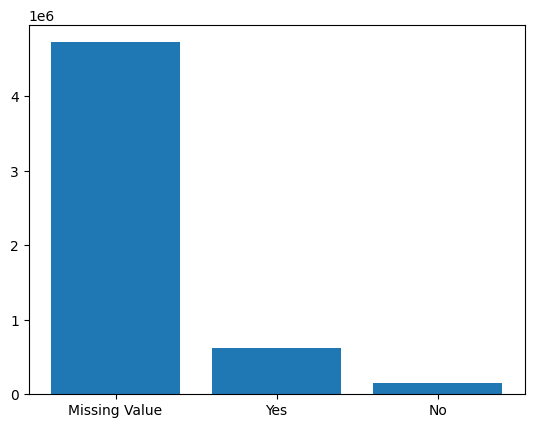

In [215]:
plt.bar(customer_data['Consumer disputed?'].unique(), customer_data['Consumer disputed?'].value_counts())

A lot of customers disputed, but there are a lot of missing values. In this context, it likely means that there was some error in the data collection process.